# Farms

The eco simulator supports the entire range of farm's functionality, including banks and IMF loans. In this document, we cover the following functionalities of the eco simulator:
1. Compound transactions (selling some defense/farms to buy more expensive defense/farms)
2. Banks & IMF Loans

In [1]:
import b2sim as b2
from copy import deepcopy as dc
import os

## More about Farm Payments

Farms have different payout rules for the round they are bought and subsequent rounds: 
1. When a farm is bought before a given round $r$, and that farm pays out $p$ dollars $k$ times per round, that farm on round $r$ will award its $i$ th payment at time $s(i-1)/k$ seconds into the round, where $s$ is how long it takes for all natural bloons to spawn.
2. When a farm is bought on a given round $r$, that farm will award its $i$ th payment of that round $si/k$ seconds after purchase, provided that all natural bloons have not already finished spawning.

**Warning:** If you run a simulation that starts at time $a$ and ends at time $b$, the simulator ignores payments that occur exactly at time $a$ but fully considers payments that occur at exactly at time $b$. There are two reasons for this practice:
1. By adopting this practice, if you run the sim from time $a$ to $b$ and then again from time $b$ to $c$, the result will be exactly the same as if you just ran it from time $a$ to $c$ to begin with.
2. If instead I chose to honor payments exactly at time $a$ but ignore those at time $b$, I would create an awkward situation where players after simulation would not know their exact wealth at time $b$, but rather their wealth *just* before reaching time $b$. This could lead to awkward scenarios where a simulation to round $25$ with a Monkey Wall Street would *not* result in the player getting $10000$ dollars right at the end of simulation.

A tradeoff of this practice is that, if you start a simulation at a given time $a$ but intend to account for payments to be received exactly at that time, you'll want to start the simulation *slightly* before time $a$ instead.

## Farm Actions in the simulator

The following actions are available for use with farms in the simulator:
1. `buyFarm()`
2. `upgradeFarm()`
3. `sellFarm()`
4. `withdrawBank()`
5. `activateIMF()`
6. `sellAllFarms()`

For a full list of arguments these actions can take, the user should look at `actions.py`. However, throughout this tutorial we'll make use of all of these actions in one example or another.

## The Round 23 Monkey Wall Street (Compound Transactions)

Let's start at Round 20, where we assume the player has access to the following farms:

| Build Item | Current Amount |
|------------|----------------|
| 320 farm   |       2        |
| 204 farm   |       1        |

Our goal is to build a second 204 farm and then sell into a 205 Monkey Wall Street. Note that it is important to specify for our starting farms that they were bought *strictly* before round 20. A farm that is bought exactly on a round start will not give a payout on that round's start.

Next, we set the buy queue. Let me make some comments here about the simulator:
1. Notice that all the actions regarding selling into MWS are placed into one item. This is because we do not want to sell our farms until we absolutely have enough cash to buy the MWS upgrade. When multiple actions are placed into one item in the buy queue, the simulator does not proceed with the actions given until it is possible to do *all* of them.
2. The parameter `buffer` forces the simulator to wait until it has the amount of cash the action costs *plus* the specified buffer amount. This is useful if you want to sustain eco'ing through transactions.
3. The parameter `min_buy_time` prevents the simulator from performing the action until the specified time is reached in the game simulation. For our MWS buy this is useful since we don't want to buy it until *right* before the end of the round. 

In [3]:
os.getcwd()
print(b2.dirname)

/home/redlaserbm/.local/lib/python3.10/site-packages/b2sim-1.2.5-py3.10.egg/b2sim


,Time,Type,Message
0,514.8,Eco,Change eco to Grouped Pinks
1,515.1,Buy,Buy Farm
2,515.2,Buy,Upgrade farm 3 at path 0
3,515.4,Buy,Upgrade farm 3 at path 0
4,515.4,Buy,Upgrade farm 3 at path 2
5,515.5,Buy,Upgrade farm 3 at path 2
6,516.0,Buy,Upgrade farm 3 at path 2
7,527.0,Round,Round 21.0 start
8,547.8,Round,Round 22.0 start
9,561.0,Eco,Change eco to Zero


,Revenue,Expenses,Profit,Eco Impact,Start Time,End Time
Farm Index,,,,,,
0,7120.0,0,7120.0,515.0,515.0,598.0
1,7120.0,0,7120.0,515.0,515.0,598.0
2,26200.0,0,26200.0,1894.0,515.0,598.0
3,4920.0,64350,-59430.0,357.0,515.0,598.0


The current cash and eco are (53.80000000018481,2511.2000000000194)


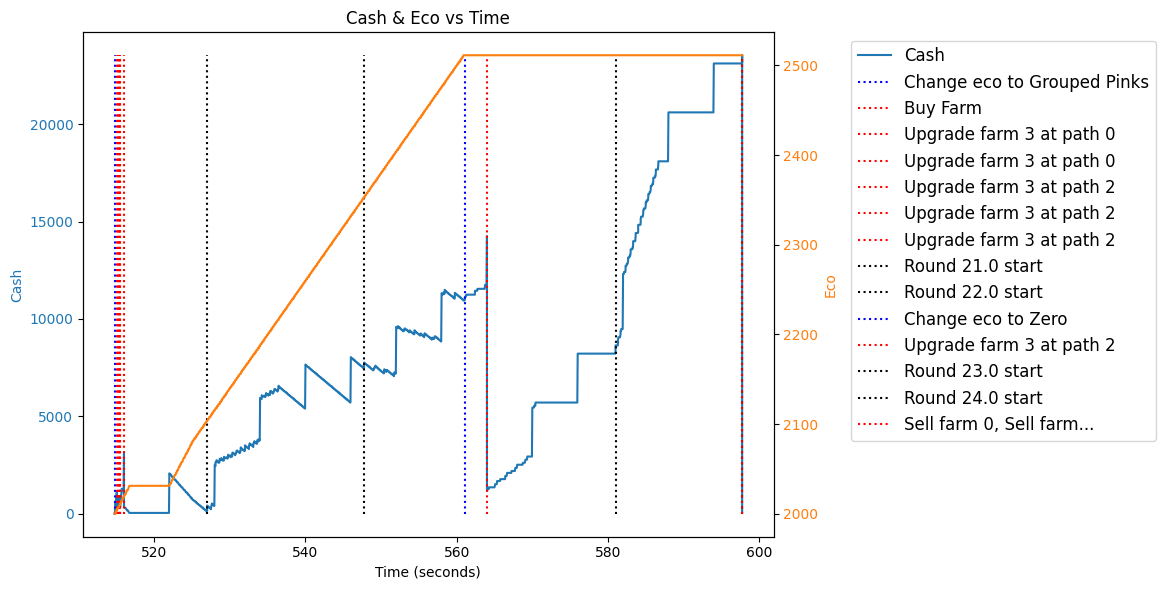

In [4]:
rounds = b2.Rounds([(0,0.5), (20,0.25),(21,0.5)]) #Set the stall factor to 0.5 for all rounds except round 20.

farms = [
    b2.initFarm(rounds.getTimeFromRound(19.9), upgrades = [3,2,0]),
    b2.initFarm(rounds.getTimeFromRound(19.9), upgrades = [3,2,0]),
    b2.initFarm(rounds.getTimeFromRound(19.9), upgrades = [2,0,4]),
]

buy_queue = [

    #Buy a 204 farm
    [b2.buyFarm(buffer = 250)],
    [b2.upgradeFarm(3,0, buffer = 250)],
    [b2.upgradeFarm(3,0, buffer = 250)],
    [b2.upgradeFarm(3,2, buffer = 250)],
    [b2.upgradeFarm(3,2, buffer = 250)],
    [b2.upgradeFarm(3,2, buffer = 250)],
    [b2.upgradeFarm(3,2, buffer = 250)],

    #As soon as we can afford to do so, sell the first three farms, and upgrade the 4th one to a Monkey Wall Street
    [b2.sellFarm(0), b2.sellFarm(1), b2.sellFarm(2), b2.upgradeFarm(3,2, min_buy_time = rounds.getTimeFromRound(24) - 1)]
]

eco_queue = [
        b2.ecoSend(rounds.getTimeFromRound(22.4), 'Zero')
]

initial_state_game = {
    'Cash': 0,
    'Eco': 2000,
    'Eco Send': b2.ecoSend(send_name='Grouped Pinks'),
    'Rounds': rounds,
    'Game Round': 20,
    'Farms': farms,
    'Buy Queue': dc(buy_queue),
    'Eco Queue': dc(eco_queue)
}

game_state = b2.GameState(initial_state_game)
game_state.fastForward(target_round = 24)
game_state.viewCashEcoHistory()
print("The current cash and eco are (%s,%s)"%(game_state.cash, game_state.eco))
b2.writeLog(game_state.logs, filename = 'mws_flowchart', path = 'logs/')

## The R16 IMF All-out

The advantage brought forth by simulation is the ability to better theory-craft flowcharts before testing them out in real games. Here, we try an unusual flowchart which involves the player selling $2 \times 320$ farms into a $042$ farm to do an allout on R16.

Recall from the previous example that if we perform a compound transaction like selling into a farm upgrade, the sell action and the upgrade action have to be listed in the same buy queue action. For this example, the acts of selling the farms *and* the acts of buying the new farm and upgrading it into 042 have to be listed together. Using just the `sellFarm` and `buyFarm` and `upgradeFarm` actions, this might be tedious to write. However, in the example below, we use the `sellAllFarms` along with the `upgrades` argument for the `buyFarm` action to make this easy to use.

,Time,Type,Message
0,284.8,Eco,Change eco to Zero
1,284.8,Buy,"Sell All Farms, Buy Farm"
2,285.0,Round,Round 14.0 start
3,297.0,Round,Round 15.0 start
4,313.4,Round,Round 16.0 start
5,346.4,Round,Round 17.0 start


,Revenue,Expenses,Profit,Eco Impact,Start Time,End Time
Farm Index,,,,,,
0,3920.0,0,3920.0,470400.0,285.0,285.0
1,3920.0,0,3920.0,470400.0,285.0,285.0
2,0.0,1000,-1000.0,0.0,285.0,346.0


The current cash and eco are (7889.999999999999,700)


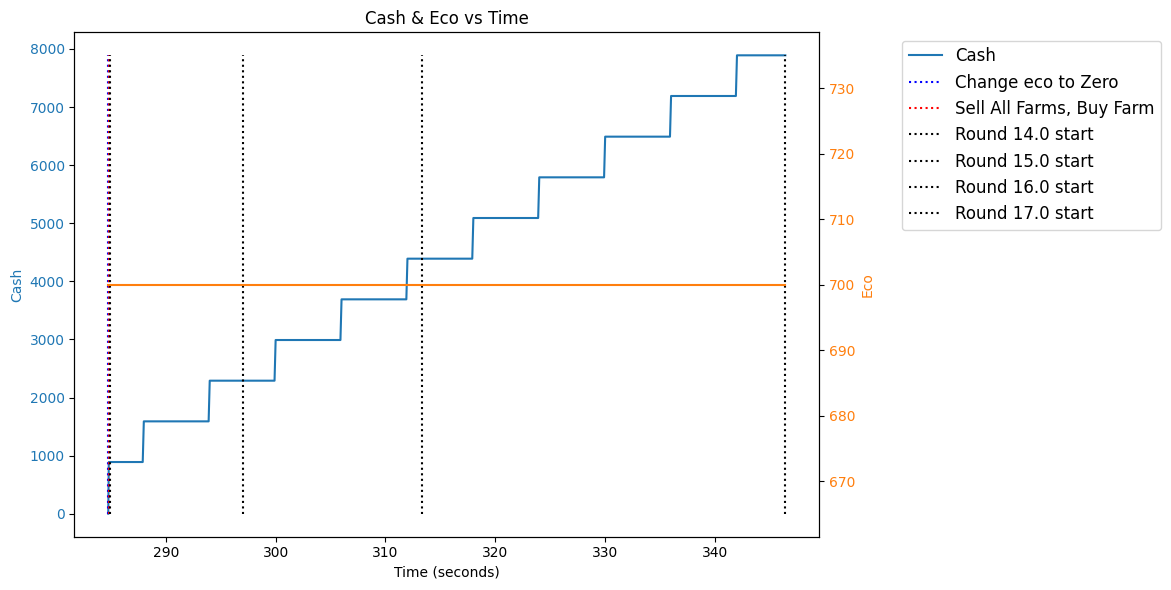

In [5]:
rounds = b2.Rounds(0.1)

farms = [
    b2.initFarm(rounds.getTimeFromRound(13.9), upgrades = [3,2,0]),
    b2.initFarm(rounds.getTimeFromRound(13.9), upgrades = [3,2,0])
]

imf_cost = 14950

buy_queue = [

    #Sell all our farms once we have the ability to insta buy 042 IMF Loan, then insta-buy IMF Loan
    [b2.sellAllFarms(), b2.buyFarm(upgrades=(0,3,2))],

    #Activate IMF as soon as we can
    # [b2.activateIMF(2), b2.sellFarm(2, withdraw = True)]
]

initial_state_game = {
    'Cash': 0,
    'Eco': 700,
    'Eco Send': b2.ecoSend(send_name='Zero'),
    'Rounds': rounds,
    'Game Round': 13.99,
    'Farms': farms,
    'Buy Queue': buy_queue
}

game_state = b2.GameState(initial_state_game)
game_state.fastForward(target_round = 17)
game_state.viewCashEcoHistory()
print("The current cash and eco are (%s,%s)"%(game_state.cash, game_state.eco))
b2.writeLog(game_state.logs, filename = 'imf_loans')

## Overclocking Farms

We can overclock farms in the simulator, thus the simulator gives us an avenue for which we can compare the consequences of buying overclock at different times in the flowchart. For now, I'll offer an example based on the standard ace engi flowchart where ideally MWS + overclock is afforded just before the end of R24.

,Time,Type,Message
0,538.1,Eco,Change eco to Zero
1,598.6,Buy,"Sell farm 0, Sell farm 1, Sell farm 2, Upgrade..."
2,599.5,Round,Round 25.0 start
3,639.3,Round,Round 26.0 start
4,643.6,Buy,Use Overclock 0 on Farm 3
5,670.3,Round,Round 27.0 start


,Revenue,Expenses,Profit,Eco Impact,Start Time,End Time
Farm Index,,,,,,
0,4670.0,0,4670.0,463.0,538.0,599.0
1,4670.0,0,4670.0,463.0,538.0,599.0
2,17400.0,0,17400.0,1726.0,538.0,599.0
3,51280.0,46000,5280.0,2327.0,538.0,670.0


The current cash and eco are (79670.0,2500)


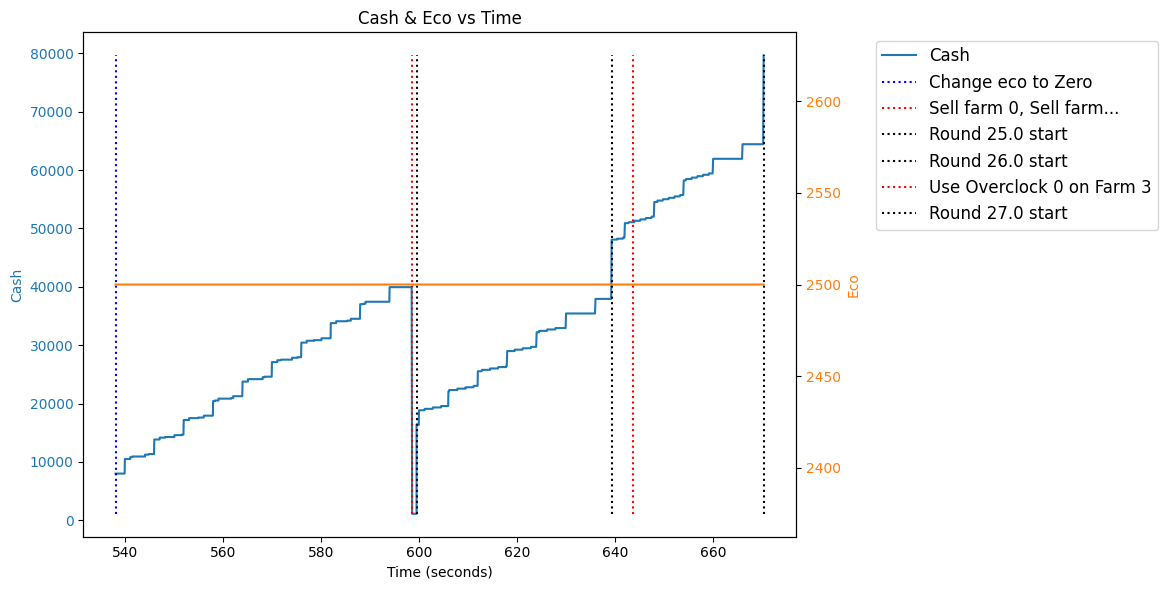

In [6]:
rounds = b2.Rounds(0.2)

farms = [
    b2.initFarm(rounds.getTimeFromRound(19.9), upgrades = [3,2,0]),
    b2.initFarm(rounds.getTimeFromRound(19.9), upgrades = [3,2,0]),
    b2.initFarm(rounds.getTimeFromRound(19.9), upgrades = [2,0,4]),
    b2.initFarm(rounds.getTimeFromRound(22), upgrades = [2,0,4])
]

buy_queue = [
    #As soon as we can afford to do so, sell the first three farms, upgrade the 4th one to a Monkey Wall Street, and buy Overclock
    [b2.sellFarm(0), b2.sellFarm(1), b2.sellFarm(2), b2.upgradeFarm(3,2, min_buy_time = rounds.getTimeFromRound(25) - 1), b2.buyOverclock()],
    [b2.useOverclock(0,3)], #Use the overclock at index zero on the farm at index 3
    [b2.useOverclock(0,3)]
]

initial_state_game = {
    'Cash': 8000,
    'Eco': 2500,
    'Eco Send': b2.ecoSend(send_name='Zero'),
    'Rounds': rounds,
    'Game Round': 24,
    'Farms': farms,
    'Buy Queue': buy_queue
}

game_state = b2.GameState(initial_state_game)
game_state.fastForward(target_round = 27)
game_state.viewCashEcoHistory()
print("The current cash and eco are (%s,%s)"%(game_state.cash, game_state.eco))
b2.writeLog(game_state.logs, filename = 'mws_overclock')

## Long-Term Money Projection With Farms

We consider passive farm play under the following scenario: Assume that we have access to 1 x 420 farms on R20 with some amount of eco. For our farming flowchart, we precommit to the following sequence of purchases and sells:

| Order |  Transactions  |
|-------|----------------|
| 1     | Buy 204 farm (index 1) |
| 2     | Sell 420 farm (index 0), upgrade to 205 farm (index 1) |
| 3     | Buy 420 farm (index 2) |
| 4     | Buy 204 farm (index 3) |
| 5     | Sell 204 farm (index 3) into 520 Farm (index 2) |

After getting these farms, we run the simulation until R31. In practice, the player might buy more farms after getting Banana Central, but the goal here is just to see what kind of money Banana Central + eco is able to generate.

,Time,Type,Message
0,448.2,Eco,Change eco to Zero
1,448.6,Buy,Buy Farm
2,448.8,Buy,"Upgrade farm 1 at path 0, Upgrade farm 1 at pa..."
3,449.0,Buy,"Upgrade farm 1 at path 2, Upgrade farm 1 at pa..."
4,456.0,Buy,Upgrade farm 1 at path 2
5,457.0,Round,Round 21.0 start
6,473.5,Round,Round 22.0 start
7,476.2,Buy,Upgrade farm 1 at path 2
8,503.8,Round,Round 23.0 start
9,516.3,Round,Round 24.0 start


,Revenue,Expenses,Profit,Eco Impact,Start Time,End Time
Farm Index,,,,,,
0,30870.0,0,30870.0,2320.0,448.0,528.0
1,96160.0,64350,31810.0,1920.0,449.0,749.0
2,70900.0,87600,-16700.0,1924.0,528.0,749.0
3,21070.0,21600,-530.0,1722.0,577.0,650.0


The current cash and eco are (145450.0,2000)


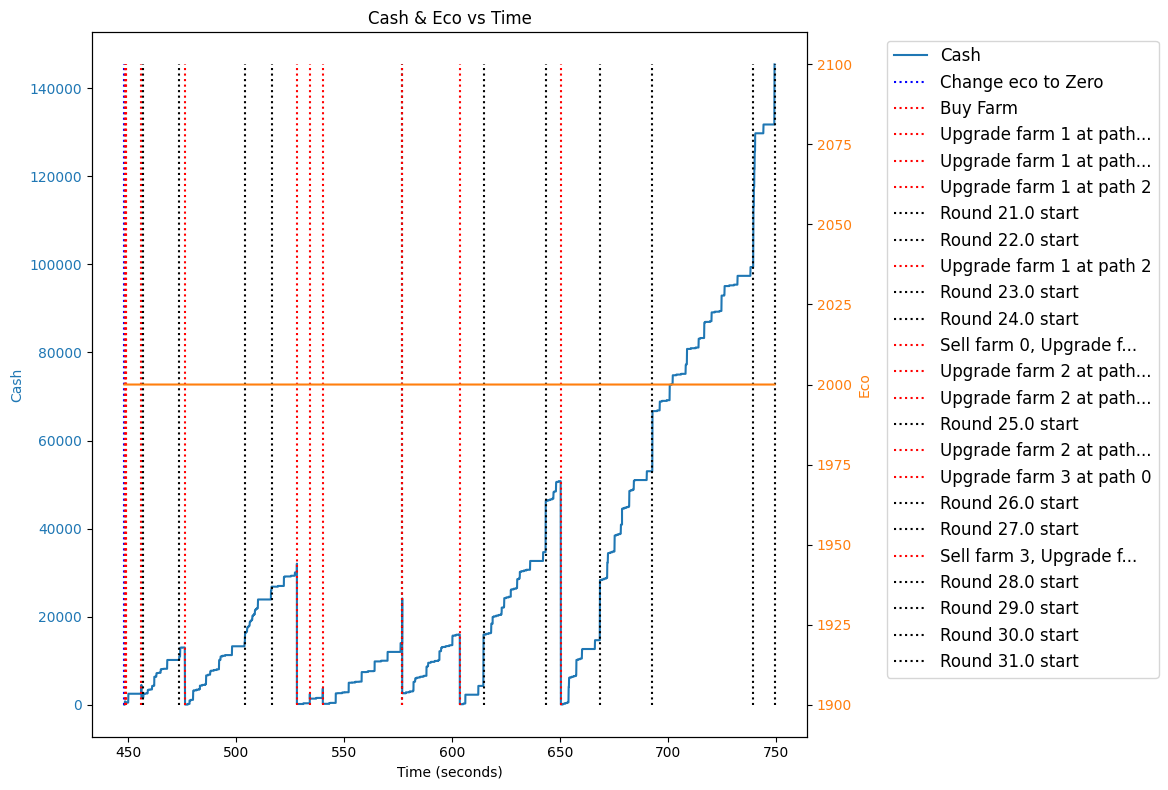

In [7]:
rounds = b2.Rounds(0.1)

farms = [
    b2.initFarm(rounds.getRoundFromTime(19.99),[4,2,0])
]

buy_queue = [

    #Purchase a 204 farm
    [b2.buyFarm()],
    [b2.upgradeFarm(1,0)],
    [b2.upgradeFarm(1,0)],
    [b2.upgradeFarm(1,2)],
    [b2.upgradeFarm(1,2)],
    [b2.upgradeFarm(1,2)],
    [b2.upgradeFarm(1,2)],

    #As soon as we have the money, sell the 420 farm & purhcase a 205 farm
    [b2.sellFarm(0), b2.upgradeFarm(1,2)],

    #Purchase a 420 farm
    [b2.buyFarm()],
    [b2.upgradeFarm(2,0)],
    [b2.upgradeFarm(2,0)],
    [b2.upgradeFarm(2,0)],
    [b2.upgradeFarm(2,1)],
    [b2.upgradeFarm(2,1)],
    [b2.upgradeFarm(2,0)],

    #Purchase a 204 farm
    [b2.buyFarm()],
    [b2.upgradeFarm(3,0)],
    [b2.upgradeFarm(3,0)],
    [b2.upgradeFarm(3,0)],
    [b2.upgradeFarm(3,1)],
    [b2.upgradeFarm(3,1)],
    [b2.upgradeFarm(3,0)],

    #As soon as we have the money, sell the 204 farm into a 520 farm
    [b2.sellFarm(3), b2.upgradeFarm(2,0)]
]

initial_state_game = {
    'Cash': 0,
    'Eco': 2000,
    'Eco Send': b2.ecoSend(send_name='Zero'),
    'Rounds': rounds,
    'Game Round': 20,
    'Farms': farms,
    'Buy Queue': buy_queue
}

game_state = b2.GameState(initial_state_game)
game_state.fastForward(target_round = 31)
game_state.viewCashEcoHistory(dim=(12,8))
print("The current cash and eco are (%s,%s)"%(game_state.cash, game_state.eco))
b2.writeLog(game_state.logs, filename = 'long_term_farming')